# Examen Deep Learning 19 Février 2018

NB n°1 : Les performances pures que vous obtiendrez ici n'ont pas trop d'importance car vous n'aurez pas le temps de faire une exploration complète des paramétrages des modèles. Le plus important est de produire le code qui vous permettrait, si vous aviez plus de temps pour les expérimentations, de réaliser efficacement les systèmes qui vous sont demandés.  

NB n°2 : Même si les performances pures n'ont pas réellement d'importance il faut que le code que vous produisez tourne et que l'apprentissage des modèles et leur évaluation produise des résultats.   


### Contexte

La classification supervisée consiste à apprendre un classifieur sur des données appartenant à un nombre fixé $K$ de classes. Les modèles obtenus sont évalués sur des données non utilisées en apprentissage mais appartenant aux mêmes classes que les données d'apprentissage.

Du fait de cette stratégie d'apprentissage, les classifieurs sont appris pour réaliser de la  classification dite fermée, c'est à dire que n'importe quelle donnée, qu'elle appartiennne à l'ensemble des $K$ classes ou pas, sera reconnue par le classifieur comme appartenant à une des $K$ classes connues.
Il s'agit bien entendu d'un comportement inadéquat pour une utilisation réelle de ces modèles.

Par ailleurs les classifieurs ne sont en général pas parfaits et on aimerait disposer d'une technique permettant de refuser de prendre une décision sur une partie des exemples (on parle de rejet) pour lesquels la décision est incertaine pour augmenter la précision de la décision sur les exemples non rejetés. 

Dans les deux cas il s'agit de mettre au point un système permettant de rejeter des données, soit parce qu'elles ne correspondant pas aux classes apprises (classification ouverte), soit parce que le système n'est pas confiant dans sa décision. 

Le travail qui vous est demandé consiste à proposer et mettre au point un système neuronal pour les cas de figures décrits ci dessus, pour obtenir  un classifieur qui  rejette une partie des données mais qui obtient sur les données qu'il ne rejette pas une bonne précision.   

Durant tout l'examen vous utiliserez les données Mnist que nous avons déjà utilisées en TP.




#### Question préliminaire: 
- En reprenant le code des TPs précédents, construisez un classifieur pour les données Mnist (de préférence convolutionnel), apprenez le sur le train et testez le. 
- Mettez en évidence le problème de ce classifieur en mode ouvert en déterminant la classe reconnue de quelques exemples d'imagettes construites aléatoirement, que vous afficherez. 

### Sujet : Architecture neuronale pour le rejet et la classification ouverte


L'architecture que vous devez mettre au point est une architecture basée sur l'adversarial learning. 

Dans une architecture adversarial learning telle que vous l'avez vue en TP, le système est constitué de deux réseaux, un générateur et un classifieur. Le discriminateur est appris à distinguer les données générées par le générateur des données issues d'une distribution empirique d'un ensemble $D$ de données d'apprentissage. Le générateur étant appris à tromper le discriminateur il tend progressivement à générer des données qui ressemblent de plus en plus aux données de la distribution empirique. Cela signifie que dans les premières itérations les données que le générateur génère ne sont pas suffisamment réalistes mais ne sont pas non plus des données aléatoires. 

L'hypothèse que vous utiliserez est que les données générées par le générateur dans les premières itérations pourraient constituer des bonnes données pour apprendre un classifieur à rejeter tout ce qui ne correspond pas aux données des classes apprises. De façon plus générale toutes les données générées par le générateur et qui sont significativement reconnues $FAKE$ par le discriminateur sont des données intéressantes pour apprendre un classifieur qui rejette les $mauvaises$ données.   

On suppose que vous disposez de données d'apprentissage, l'ensemble $D$, (et de test, $T$) qui appartiennent à $K$ classes. 

L'architecture qu'il vous est demandé de concevoir est composée de:
- Un générateur (appelé $generator$) et un discriminateur (appelé $discriminator$) comme dans le cas de l'adversarial learning. Le générateur prend en entrée un bruit gaussien en dimension 50 à 100 et produit des images de format $(28,28)$. Le discriminateur prend en entrée une image $(28,28)$ et produit une sortie entre 0 et 1 (plus proche de 1 si l'exemple est consédéré $True$ et plus proche de 0 si il est considéré $Fake$) 
- Un classifieur, appelé ${prediction\_model}$, qui fait de la classification de données en $K$ classes. Il prend en entrée une image $(28,28)$ et produit en sortie un vecteur de  $K$ valeurs correspondant à la classification de l'exemple dans les $K$ classes
- Un classifieur, appelé $rejection\_model$, prenant en entrée des images $(28,28)$ et produisant en sortie une sortie entre 0 et 1 (1 signifiant que l'exemple est considéré valide et 0 que l'exemple doit être rejeté).

Une fois appris le système composé de ces 4 modèles, on dispose d'un système de classification capable de rejeter, qui s'utilise comme suit pour le traitement d'une donnée $x$:
- La donnée $x$ est passée dans le $rejection\_model$ qui produit une décision. Si la décision est que l'exemple n'est pas valide il est rejeté.
- SI l'exemple n'a pas été rejeté par le $rejection\_model$ il est traité par le $prediction\_model$ qui le classe dans une des $K$ classes.

La performance du système est évaluée sur un jeu de test $T$ à l'aide des mesures suivantes :
- taux de rejet: C'est le pourcentage d'exemples de test qui sont rejetés: $\frac{N_{Rejetés}}{N}$
- taux de faux negatifs :  C'est le pourcentage d'exemples de test qui sont rejetés alors qu'ils seraient bien classés par le $prediction\_model$:  $\frac{N_{Rejetés\_et\_bien\_classés}}{N_{Rejetés}}$
- taux de vrais négatifs : C'est le pourcentage d'exemples de test qui sont rejetés et qui ne seraient pas bien classés par le $prediction\_model$ : $\frac{N_{Rejetés\_et\_mal\_classés}}{N_{Rejetés}}$
- taux de faux positifs : C'est le pourcentage d'exemples de test qui ne sont pas rejetés alors qu'ils sont mal classés par le $prediction\_model$: $\frac{N_{Acceptés\_et\_mal\_classés}}{N_{Acceptés}}$
- taux de vrais positifs : C'est le pourcentage d'exemples de test qui ne sont pas rejetés et qui sont bien classés par le $prediction\_model$: $\frac{N_{Acceptés\_et\_bien\_classés}}{N_{Acceptés}}$
- précicion : C'est le pourcentage d'exemples non rejetés et qui sont  bien classés sur le nombre d'exemples non rejetés: $\frac{N_{Acceptés\_et\_bien\_classés}}{N_{Acceptés}}$

### Partie 1

Vous vous intéresserez tout d'abord à construire un système pour le rejet de données sur lesquelles le classifieur est incertain. Votre classifieur, le $prediction\_model$ opère sur les données de 10 classes et votre $rejection\_model$ également. Le but est que le $rejection\_model$ prédise (et donc rejette) les données de la base de test Mnist sur lequelles le $prediction\_model$  va se tromper.



#### Question2 

Ecrivez le code correspondant à la construction des modèles nécessaires. Vous ferez attention à l'utilisation de $trainable = False$ qui permet si il est utilisé sur un modèle avant la compilation de ne pas apprendre ses poids.

#### Question3 

Ecrivez le code correspondant à l'évaluation des modèles. 

#### Question 4

Ecrivez le code correspondant à la construction de batchs d'apprentissage pour les différents modèles. 

Il vous faudra au fur et à mesure conserver l'ensemble ou un sous ensemble des données générés par le générateur au long des itérations comme exemples potentiellement négatifs pour le $rejection\_model$.


#### Question 5 

Ecrivez le code de l'apprentissage. Les deux modèles $prediction\_model$ et $rejection\_model$ doivent être appris par batch tout comme le $discriminator$ et le $generator$. 

- L'apprentissage consiste en une boucle sur les itérations d'apprentissage (les epochs). 
- Chaque epoch consiste en une itération sur des batchs. 
- Pour chaque batch (on utilise une taille batchSize d'exemples) on fait une étape de réestimation du $discriminator$, du $generator$, du $prediction\_model$ et du $rejection\_model$.



### Partie 2

Il s'agit ici de s'intéresser au problème de classification ouverte. Le mode d'apprentisssage est donc un peu différent. En apprentissage vous ne disposez de données d'apprentissage que pour un ensemble limité de classes (par exemple $P <10$). En test vous disposez de données des $P$ classes apprises et des $K-P$ autres classes. 

Le $prediction\_model$ a donc seulement $P$ sorties (mais en réalité vous pouvez utiliser le même classifieur à 10 sorties, seules $P$ seront utilisées en réalité). Le $rejection\_model$ doit être capable de ne pas rejeter les données des $P$ classes apprises, surtout si le $prediction\_model$ les classe bien, et doit rejeter au maximum les données des  $K-P$ autres classes puisque sa décision sera nécessairement fausse sur ces données.

#### Questions 1 à 5
Adaptez les codes de la partie 1 pour ce cas d'études.
La création des modèles, les mesures d'évaluation, la constitution des batchs d'apprentissage etc doivent être adaptés pour cette nouvelle situation.  

## Pour démarrer

Le code est prévu pour colab mais peut fonctionner sur les machines de l'école pourvu que vous enleviez certains imports et quelques appels aux fonctions de download de fichiers distants. 

#### Installation et imports nécessaires sur colab
Changez le type des cellules suivantes en $Code$ pour les executer 

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


import tensorflow as tf
import timeit

Found GPU at: /device:GPU:0


In [2]:
!pip install -q keras
import keras

!pip install -q tqdm
import tqdm

Using TensorFlow backend.


#### Import des données

In [ ]:
import os

In [ ]:
import tensorflow as tf
import timeit


import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras.utils import np_utils
from __future__ import print_function
from __future__ import absolute_import
import pylab as pl
import pandas as pd
import matplotlib.cm as cm
from keras import backend as K 
from keras.models import load_model
%matplotlib inline

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1337)  # for reproducibility

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]
Y_train = np_utils.to_categorical(y_train, nb_classes)

X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:, np.newaxis, :, :]
Y_test = np_utils.to_categorical(y_test, nb_classes)



In [13]:
X_train.shape

(60000, 1, 28, 28)

#### Plots des critères d'apprentissage et des images générées

In [ ]:
## Code adapté à colab

from google.colab import files

# Plot the loss from each batch
# dLosses et gLosses sont des listes des loss par epoque pour le discriminateur et le generateur
def plotLoss(dLosses, gLosses):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

# Create a wall of generated MNIST images
# genere des donnees avec le modele generateur passe en parametre avec une couche d'entree de taille
# randomDim, et recupere le fichier des données générées
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

    

#### Basic model & training function

In [15]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3),
                             border_mode='valid',
                             input_shape=(1,28,28)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(32, (3,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(100))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))

model1.compile(loss='categorical_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 11, 11)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 11, 11)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 5, 5)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 5, 5)          0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(1, 28, 28...)`
  """


In [16]:
model1.fit(X_train, Y_train, batch_size=64, nb_epoch=3)

/usr/local/lib/python2.7/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
60000/60000 [==============================] - 10s 159us/step - loss: 0.3740 - acc: 0.8831
Epoch 2/3
60000/60000 [==============================] - 9s 144us/step - loss: 0.1594 - acc: 0.9525
Epoch 3/3
60000/60000 [==============================] - 9s 142us/step - loss: 0.1289 - acc: 0.9620


In [17]:

score = model1.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.04571910453605233
Test accuracy: 0.9859


On remarque que le réseau associe un bruit uniforme à des 8. Cela reflète le problème des classifieurs fermés.


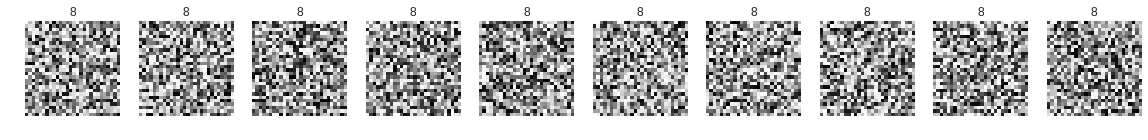

In [83]:
#Images aléatoires + catégorisation
plt.figure(figsize=(20,20))
for i in xrange(10):
  im = np.random.rand(28,28)
  temp=np.array([im,])
  temp=np.array([temp,])
  plt.subplot(1,10,i+1)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(im, interpolation='nearest')
  results = model1.predict([temp,])
  best = np.flip(np.argsort(results)[0],0)[0]
  plt.title(best)


print("On remarque que le réseau associe un bruit uniforme à des 8. Cela reflète le problème des classifieurs fermés.")

#### Partie 1

##### Generator and Discriminator models

In [128]:
nb_filters=32


adam = Adam(lr=0.0002, beta_1=0.5)

# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

generator.add(Conv2D(1, kernel_size=(2,2),padding='same'))


generator.compile(loss='binary_crossentropy', optimizer=adam)
print(generator.summary())

# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(nb_filters, kernel_size=(3,3),
                                 border_mode='valid',
                                 input_shape=((1,28,28))))
discriminator.add(Activation('relu'))

discriminator.add(MaxPooling2D(pool_size=(2,2)))
discriminator.add(Conv2D(nb_filters, kernel_size=(3,3)))
discriminator.add(Activation('relu'))

discriminator.add(MaxPooling2D(pool_size=(2,2)))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())
discriminator.add(Dense(100))

discriminator.add(Activation('relu'))
discriminator.add(Dropout(0.5))

discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))


discriminator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 64, 28, 28)        0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, padding="valid", input_shape=(1, 28, 28..., kernel_size=(3, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
activation_50 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 11, 11)        9248      
_________________________________________________________________
activation_51 (Activation)   (None, 32, 11, 11)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 5, 5)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 5, 5)          0         
__________

In [ ]:
x = Input(shape=(randomDim,))
y=generator(x)
discriminator.trainable=False
z=discriminator(y)

gan=Model(inputs=x,outputs=z)
gan.compile(optimizer="adam", loss="binary_crossentropy")

##### Prediction and rejection models

In [130]:
#Definition of the prediction model
prediction_model = Sequential()

prediction_model.add(Conv2D(32, (3,3),
                             border_mode='valid',
                             input_shape=(1,28,28)))
prediction_model.add(Activation('relu'))
prediction_model.add(MaxPooling2D(pool_size=(2,2)))
prediction_model.add(Conv2D(32, (3,3)))
prediction_model.add(Activation('relu'))
prediction_model.add(MaxPooling2D(pool_size=(2,2)))
prediction_model.add(Dropout(0.5))

prediction_model.add(Flatten())
prediction_model.add(Dense(100))
prediction_model.add(Activation('relu'))
prediction_model.add(Dropout(0.5))
prediction_model.add(Dense(nb_classes))
prediction_model.add(Activation('softmax'))

prediction_model.compile(loss='categorical_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])
prediction_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
activation_54 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 11, 11)        9248      
_________________________________________________________________
activation_55 (Activation)   (None, 32, 11, 11)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 5, 5)          0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 5, 5)          0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(1, 28, 28...)`
  """


In [131]:
rejection_model = Sequential()

rejection_model.add(Conv2D(32, (3,3),
                             border_mode='valid',
                             input_shape=(1,28,28)))
rejection_model.add(Activation('relu'))
rejection_model.add(MaxPooling2D(pool_size=(2,2)))
rejection_model.add(Conv2D(32, (3,3)))
rejection_model.add(Activation('relu'))
rejection_model.add(MaxPooling2D(pool_size=(2,2)))
rejection_model.add(Dropout(0.5))

rejection_model.add(Flatten())
rejection_model.add(Dense(100))
rejection_model.add(Activation('relu'))
rejection_model.add(Dropout(0.5))
rejection_model.add(Dense(1))
rejection_model.add(Activation('sigmoid'))

rejection_model.compile(loss='binary_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])
rejection_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
activation_58 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 11, 11)        9248      
_________________________________________________________________
activation_59 (Activation)   (None, 32, 11, 11)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 5, 5)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 32, 5, 5)          0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(1, 28, 28...)`
  """


##### Définition de la fonction train

In [ ]:
def train(X_train, Y_train, X_test, Y_test, epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print (type(batchCount))
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    dLosses = []
    gLosses = []
    cLosses_r = []
    cLosses_p = []
    
    for e in xrange(1, epochs+1):
        print('\n')
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        closs_r=0
        closs_p=0
        dloss=0
        gloss=0
        for _ in tqdm(xrange(batchCount)):
          
            # Batch training for all models
            
            
            
            #Creation of batches for the generative model
            
            current_choice = np.random.choice(X_train.shape[0], batchSize, replace=False)
            
            minibatch_d=X_train[current_choice, :]
            minibatch_labels=Y_train[current_choice, :]
            minibatch_z=np.random.normal(0, 1, size=[batchSize, randomDim])
            minibatch_g=generator.predict(minibatch_z)
            
            y_d=np.ones(batchSize)
            y_g=np.zeros(batchSize)
            
            X_temp = np.concatenate((minibatch_d,minibatch_g))
            Y_temp = np.concatenate((y_d,y_g))
            
            Z=np.random.normal(0, 1, size=[batchSize, randomDim])
            y_gan=np.ones(batchSize)
          
            #Training the discriminator and the generator
            dloss+=discriminator.train_on_batch(X_temp,Y_temp)
            gloss+=gan.train_on_batch(Z,y_gan)
            
            
            #Training the prediction and rejection models
            closs_p+=np.sum(prediction_model.train_on_batch(minibatch_d,minibatch_labels))
            
            Y_predict = prediction_model.predict(minibatch_d)
            keep=[]
            
            for i in xrange(minibatch_d.shape[0]):
              if np.argmax(Y_predict[i],0)==np.argmax(minibatch_labels[i],0):
                keep.append(1)
              else:
                keep.append(0)
            
            keep = np.concatenate((keep, np.zeros(batchSize)))
            
            closs_r = rejection_model.train_on_batch(X_temp, keep)
                

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        cLosses_r.append(closs_r)
        cLosses_p.append(closs_p)
        
        
        
        
    
    plotGeneratedImages(epochs)
   
    # Plot losses from every epoch
    plotLoss(dLosses,gLosses)
      
    # Performance evaluation
    Nb_rejets=0
    Nb_faux_negatifs=0
    Nb_vrai_negatifs=0
    Nb_faux_positifs=0
    Nb_vrai_positifs=0
    N = X_test.shape[0]
    
    
    #Generation of artificial data
    noise = np.random.normal(0, 1, size=[N, randomDim])
    X_test_false=generator.predict(noise)
    Y_test_false=np.zeros((N,nb_classes))
    
    X_test_reject = np.concatenate((X_test,X_test_false))
    Y_test_reject = np.concatenate((Y_test,Y_test_false))
    #Classification
    rejected = rejection_model.predict(X_test_reject)
    class_predicted = prediction_model.predict(X_test_reject)

    for i in xrange(N*2):
      if rejected[i]<0.5:
        Nb_rejets+=1
        if np.argmax(class_predicted[i],0)==np.argmax(Y_test_reject[i]) and np.amax(Y_test_reject[i])==1:
          Nb_faux_negatifs+=1
        else:
          Nb_vrai_negatifs+=1
          
      else:
        if np.argmax(class_predicted[i],0)==np.argmax(Y_test_reject[i]) and np.amax(Y_test_reject[i])==1:
          Nb_vrai_positifs+=1
        else:
          Nb_faux_positifs+=1
          
    print("Taux de rejet : %.3f"%(float(Nb_rejets)/(2*N)))
    print("Taux de faux négatifs : %.3f"%(float(Nb_faux_negatifs)/Nb_rejets))
    print("Taux de vrai negatifs : %.3f"%(float(Nb_vrai_negatifs)/Nb_rejets))
    print("Taux de faux positifs : %.3f"%(float(Nb_faux_positifs)/(2*N-Nb_rejets)))
    print("Taux de vrai positifs : %.3f"%(float(Nb_vrai_positifs)/(2*N-Nb_rejets)))

    return(float(Nb_rejets)/(2*N),
           float(Nb_faux_negatifs)/Nb_rejets,
           float(Nb_vrai_negatifs)/Nb_rejets,
           float(Nb_faux_positifs)/((2*N)-Nb_rejets),
           float(Nb_vrai_positifs)/((2*N)-Nb_rejets))

##### Training the models

  0%|          | 0/468 [00:00<?, ?it/s]

<type 'int'>
Epochs: 5
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:42, 10.94it/s]



--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:42, 11.06it/s]



--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:42, 10.97it/s]



--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:41, 11.18it/s]



--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:42<00:00, 11.11it/s]


Taux de rejet : 0.500
Taux de faux négatifs : 0.000
Taux de vrai negatifs : 1.000
Taux de faux positifs : 0.012
Taux de vrai positifs : 0.988


(0.50015,
 0.00029991002699190244,
 0.9997000899730081,
 0.011503451035310593,
 0.9884965489646894)

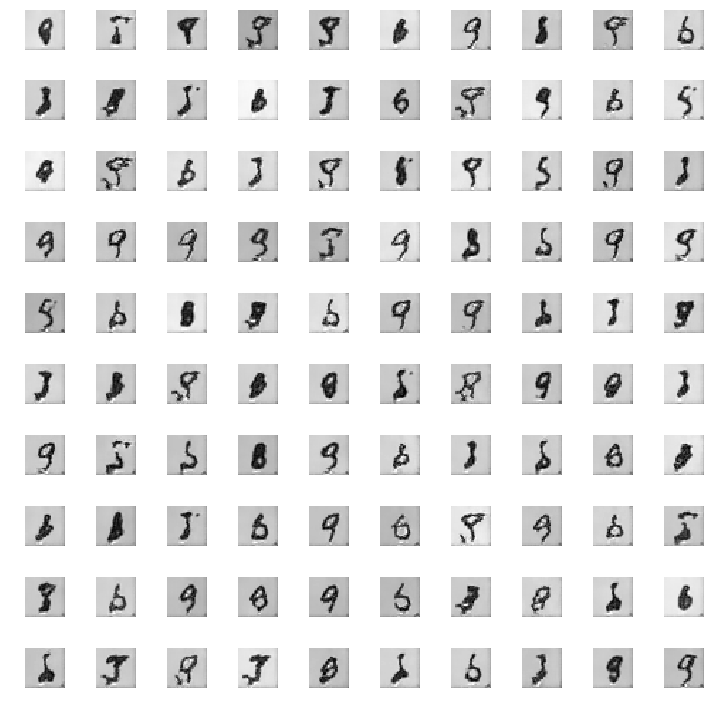

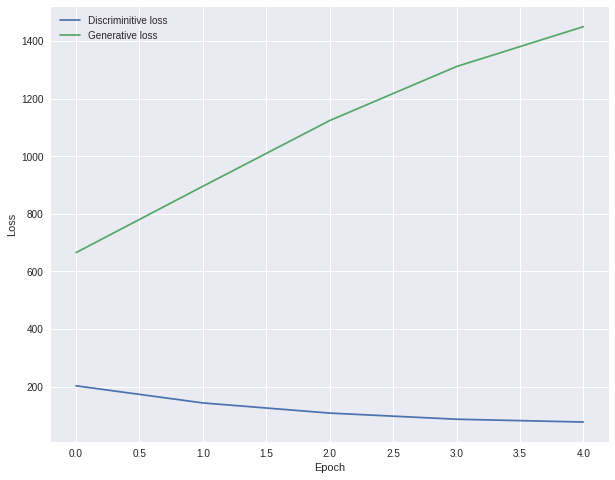

In [133]:
train(X_train, Y_train, X_test, Y_test, 5)

On voit bien ci-dessus que le rejection_model fait la différence entre les inputs venant du generator et ceux venant de mnist, et qu'il génère très peu de faux négatifs. Par ailleurs, le prediction_model réussi à identifier la quasi-totalité de ce que le rejection_model lui laisse.

En l'entraînant simplement sur 5 epochs, les modèles apprennent donc suffisamment pour reconnaître des entrées aléatoires ou générées de données réelles. 

## Pour démarrer Partie 2

#### Construction de jeux de données pour la classification ouverte
Ici les jeux de données sont créés pour être utilisés avec un classifieur à 10 sorties.

Les jeux de données créés sont:
- X_train_restricted et Y_train_restricted: jeux de données extraits de la base de train et correspondant aux données des classes dans l'ensemble $Classes\_Train$. C'est sur ces données qu'il faut apprendre votre système 
- X_test_restricted et Y_test_restricted: jeux de données extraits de la base de test et correspondant aux classes dans $Classes\_Train$. Cees données devraient être en très grande majorité acceptée par votre modèle de rejet et bien classées par votre modèle de prédiction
- X_test_out et Y_test_out: jeux de données extraits de la base de test et correspondant aux classes non présentes dans $Classes\_Train$. Ces données devraient être en très grande majorité rejetées par votre modèle de rejet.

NB: tous les jeux de données sont permutées aléatoirement dans le code ci-dessous.

In [147]:
from sets import Set


### On tire au hasard les classes à garder en train

classes_train = np.random.choice(range(nb_classes), size=3, replace=False)

Classes_Train = Set (classes_train)

X=[]
Y=[]
X2=[]
Y2=[]

#print(y_train.shape)

for y in range(nb_classes):
  if (y in Classes_Train):
      indices = np.where(y_train==y)
      #print (indices[0].shape)
      X.append(X_train[indices])
      Y.append(Y_train[indices])
  else:
      indices = np.where(y_train==y)
      #print (indices[0].shape)
      X2.append(X_train[indices])
      Y2.append(Y_train[indices])
      

def list2nparray(L):
  M = L[0]
  for i in np.arange(1,len(L)):
    M = np.concatenate((M, L[i]))
  return M

X_train_restricted = list2nparray(X)
Y_train_restricted = list2nparray(Y)

p = np.random.permutation(range(X_train_restricted.shape[0]))
X_train_restricted = X_train_restricted[p]
Y_train_restricted = Y_train_restricted[p]


X_train_out = list2nparray(X2)
Y_train_out = list2nparray(Y2)

print (X_train_restricted.shape, Y_train_restricted.shape)

print (X_test.shape, Y_test.shape)

######## Idem sur le test set

X=[]
Y=[]
X2=[]
Y2=[]

#print(y_train.shape)

for y in range(nb_classes):
  if (y in Classes_Train):
      indices = np.where(y_test==y)
      #print (indices[0].shape)
      X.append(X_test[indices])
      Y.append(Y_test[indices])
  else:
      indices = np.where(y_test
                         ==y)
      #print (indices[0].shape)
      X2.append(X_test[indices])
      Y2.append(Y_test[indices])
      

X_test_restricted = list2nparray(X)
Y_test_restricted = list2nparray(Y)

X_test_out = list2nparray(X2)
Y_test_out = list2nparray(Y2)

print (X_test_restricted.shape, Y_test_restricted.shape)

print (X_test_out.shape, Y_test_out.shape)

(17528, 1, 28, 28) (17528, 10)
(10000, 1, 28, 28) (10000, 10)
(2902, 1, 28, 28) (2902, 10)
(7098, 1, 28, 28) (7098, 10)


##### Prediction_model and Rejection_model

In [149]:
#Definition of the prediction model
prediction_res = Sequential()

prediction_res.add(Conv2D(32, (3,3),
                             border_mode='valid',
                             input_shape=(1,28,28)))
prediction_res.add(Activation('relu'))
prediction_res.add(MaxPooling2D(pool_size=(2,2)))
prediction_res.add(Conv2D(32, (3,3)))
prediction_res.add(Activation('relu'))
prediction_res.add(MaxPooling2D(pool_size=(2,2)))
prediction_res.add(Dropout(0.5))

prediction_res.add(Flatten())
prediction_res.add(Dense(100))
prediction_res.add(Activation('relu'))
prediction_res.add(Dropout(0.5))
prediction_res.add(Dense(nb_classes))
prediction_res.add(Activation('softmax'))

prediction_res.compile(loss='categorical_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])
prediction_res.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
activation_70 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 11, 11)        9248      
_________________________________________________________________
activation_71 (Activation)   (None, 32, 11, 11)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 5, 5)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 32, 5, 5)          0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(1, 28, 28...)`
  """


In [137]:
rejection_res = Sequential()

rejection_res.add(Conv2D(32, (3,3),
                             border_mode='valid',
                             input_shape=(1,28,28)))
rejection_res.add(Activation('relu'))
rejection_res.add(MaxPooling2D(pool_size=(2,2)))
rejection_res.add(Conv2D(32, (3,3)))
rejection_res.add(Activation('relu'))
rejection_res.add(MaxPooling2D(pool_size=(2,2)))
rejection_res.add(Dropout(0.5))

rejection_res.add(Flatten())
rejection_res.add(Dense(100))
rejection_res.add(Activation('relu'))
rejection_res.add(Dropout(0.5))
rejection_res.add(Dense(1))
rejection_res.add(Activation('sigmoid'))

rejection_res.compile(loss='binary_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])
rejection_res.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
activation_66 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 11, 11)        9248      
_________________________________________________________________
activation_67 (Activation)   (None, 32, 11, 11)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 5, 5)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 5, 5)          0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(1, 28, 28...)`
  """


##### Definition of train_restricted

In [ ]:
def train_restricted(X_train, Y_train, 
                     X_test_restricted,Y_test_restricted,
                     X_train_out,Y_train_out,
                     X_test_out,Y_test_out, 
                     epochs=1, batchSize=128):
  
    batchCount = int(X_train.shape[0] / batchSize)
    print (type(batchCount))
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    cLosses_r = []
    cLosses_p = []
    
    for e in xrange(1, epochs+1):
        print('\n')
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        closs_r=0
        closs_p=0
        dloss=0
        gloss=0
        for _ in tqdm(xrange(batchCount)):
          
            # Batch training for all models
            
            
            
            #Creation of batches for the generative model
            
            current_choice = np.random.choice(X_train_restricted.shape[0], batchSize, replace=False)
            
            batch = X_train_restricted[current_choice, :]
            batch_labels = Y_train_restricted[current_choice, :]
            
            #Training the prediction and rejection models
            closs_p+=np.sum(prediction_res.train_on_batch(batch,batch_labels))
            
            Y_predict = prediction_res.predict(batch)
            
            keep=[]
            for i in xrange(batch.shape[0]):
              if np.argmax(Y_predict[i],0)==np.argmax(batch_labels[i],0):
                keep.append(1)
              else:
                keep.append(0)

            keep = np.concatenate((keep, np.zeros(batchSize)))
            X_temp = np.concatenate((batch,X_train_out[
                np.random.choice(X_train_restricted.shape[0], batchSize, replace=False)
                ,:]))
            
            closs_r = rejection_res.train_on_batch(X_temp, keep)
                

        # Store loss of most recent batch from this epoch
        cLosses_r.append(closs_r)
        cLosses_p.append(closs_p)

      
    # Performance evaluation
    Nb_rejets=0
    Nb_faux_negatifs=0
    Nb_vrai_negatifs=0
    Nb_faux_positifs=0
    Nb_vrai_positifs=0
    
    #Concatenation of data
    X_test_complete=np.concatenate((X_test_restricted,X_test_out))
    Y_test_complete=np.concatenate((Y_test_restricted,np.zeros((X_test_out.shape[0],nb_classes))))

    #Classification
    rejected = rejection_model.predict(X_test_complete)
    class_predicted = prediction_model.predict(X_test_complete)

    N=X_test_complete.shape[0]
    
    for i in xrange(N):
      if rejected[i]<0.5:
        Nb_rejets+=1
        if np.argmax(class_predicted[i],0)==np.argmax(Y_test_complete[i]) and np.amax(Y_test_complete[i])==1:
          Nb_faux_negatifs+=1
        else:
          Nb_vrai_negatifs+=1
          
      else:
        if np.argmax(class_predicted[i],0)==np.argmax(Y_test_complete[i]) and np.amax(Y_test_complete[i])==1:
          Nb_vrai_positifs+=1
        else:
          Nb_faux_positifs+=1
          
    print("Taux de rejet : %.3f"%(float(Nb_rejets)/(N)))
    print("Taux de faux négatifs : %.3f"%(float(Nb_faux_negatifs)/Nb_rejets))
    print("Taux de vrai negatifs : %.3f"%(float(Nb_vrai_negatifs)/Nb_rejets))
    print("Taux de faux positifs : %.3f"%(float(Nb_faux_positifs)/(N-Nb_rejets)))
    print("Taux de vrai positifs : %.3f"%(float(Nb_vrai_positifs)/(N-Nb_rejets)))

    return(float(Nb_rejets)/(N),
           float(Nb_faux_negatifs)/Nb_rejets,
           float(Nb_vrai_negatifs)/Nb_rejets,
           float(Nb_faux_positifs)/((N)-Nb_rejets),
           float(Nb_vrai_positifs)/((N)-Nb_rejets))

##### Training of the models

In [ ]:
prediction_res.compile(loss='categorical_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])

rejection_res.compile(loss='binary_crossentropy',
                   optimizer='adadelta',
                   metrics=['accuracy'])

In [ ]:
classes_train = np.random.choice(range(nb_classes), size=3, replace=False)

Classes_Train = Set (classes_train)


In [152]:
print(classes_train)

[5 3 7]


  0%|          | 0/937 [00:00<?, ?it/s]

<type 'int'>
Epochs: 5
Batch size: 64
Batches per epoch: 937


--------------- Epoch 1 ---------------


  0%|          | 4/937 [00:00<00:25, 37.26it/s]



--------------- Epoch 2 ---------------


  0%|          | 4/937 [00:00<00:23, 39.72it/s]



--------------- Epoch 3 ---------------


  0%|          | 4/937 [00:00<00:24, 38.71it/s]



--------------- Epoch 4 ---------------


  0%|          | 4/937 [00:00<00:24, 37.89it/s]



--------------- Epoch 5 ---------------


100%|██████████| 937/937 [00:24<00:00, 38.65it/s]


Taux de rejet : 0.000
Taux de faux négatifs : 0.000
Taux de vrai negatifs : 1.000
Taux de faux positifs : 0.714
Taux de vrai positifs : 0.286


(0.0003, 0.0, 1.0, 0.7136140842252676, 0.28638591577473244)

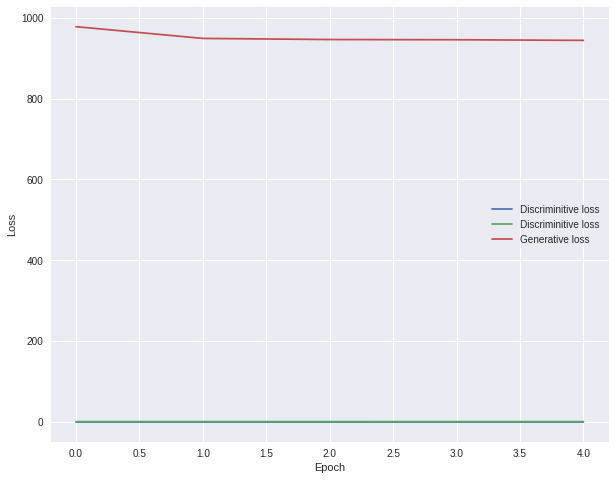

In [153]:
train_restricted(X_train, Y_train, 
                     X_test_restricted,Y_test_restricted,
                     X_train_out,Y_train_out,
                     X_test_out,Y_test_out,
                     5,64)